In [1]:
!git clone https://github.com/LJThao/atlas-gan.git


Cloning into 'atlas-gan'...
remote: Enumerating objects: 165, done.
remote: Total 165 (delta 0), reused 0 (delta 0), pack-reused 165 (from 1)
Receiving objects: 100% (165/165), 104.62 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (43/43), done.


Using Dataset CelebA (Celebrity Face Generation) for this project because it is more complex, has over 200,000 images, and works with DCGAN.

Downloading and setting up Dataset

In [3]:
import torch

In [7]:
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Download CelebA and create DataLoader
train_dataset = CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Files already downloaded and verified


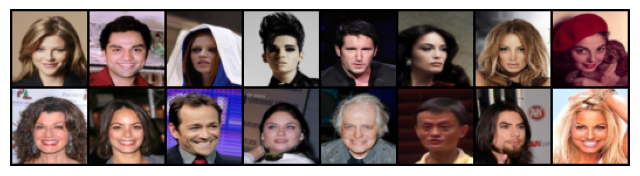

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Testing a batch
real_images, _ = next(iter(train_loader))

# Displaying images
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(real_images[:16], normalize=True).permute(1, 2, 0).cpu())
plt.show()

Baseline GAN

In [8]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

latent_dim = 100
generator = Generator(latent_dim).to(device)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)

In [10]:
crit = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
import numpy as np

n_epochs = 10
latent_dim = 100

for epoch in range(n_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)  # Move tensor to GPU
        batch_size = real_images.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_output = discriminator(real_images)
        real_loss = crit(real_output, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        fake_loss = crit(fake_output, fake_labels)

        # Total Discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        fake_output = discriminator(fake_images)
        g_loss = crit(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        # Log Progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

Epoch [1/10], Step [0/5087], D Loss: 1.3992, G Loss: 0.6853
Epoch [1/10], Step [100/5087], D Loss: 0.0787, G Loss: 9.7373
Epoch [1/10], Step [200/5087], D Loss: 0.1324, G Loss: 4.1343
Epoch [1/10], Step [300/5087], D Loss: 0.3721, G Loss: 4.1550
Epoch [1/10], Step [400/5087], D Loss: 0.2580, G Loss: 2.8615
Epoch [1/10], Step [500/5087], D Loss: 0.2967, G Loss: 2.6408
Epoch [1/10], Step [600/5087], D Loss: 0.5867, G Loss: 1.8583
Epoch [1/10], Step [700/5087], D Loss: 0.7032, G Loss: 2.1957
Epoch [1/10], Step [800/5087], D Loss: 1.0712, G Loss: 1.0630
Epoch [1/10], Step [900/5087], D Loss: 0.9008, G Loss: 1.4754
Epoch [1/10], Step [1000/5087], D Loss: 1.1042, G Loss: 0.8986
Epoch [1/10], Step [1100/5087], D Loss: 1.0604, G Loss: 1.2094
Epoch [1/10], Step [1200/5087], D Loss: 0.9535, G Loss: 1.3343
Epoch [1/10], Step [1300/5087], D Loss: 1.0705, G Loss: 1.0125
Epoch [1/10], Step [1400/5087], D Loss: 0.7439, G Loss: 2.0640
Epoch [1/10], Step [1500/5087], D Loss: 1.1483, G Loss: 1.2927
Epoc

In [15]:
import os

os.makedirs('/content/atlas-gan/advanced_gan/base/base_models', exist_ok=True)
os.makedirs('/content/atlas-gan/advanced_gan/base/base_logs', exist_ok=True)
os.makedirs('/content/atlas-gan/advanced_gan/base/base_images', exist_ok=True)


In [16]:
# Save models
torch.save(generator.state_dict(), '/content/atlas-gan/advanced_gan/base/base_models/generator.pth')
torch.save(discriminator.state_dict(), '/content/atlas-gan/advanced_gan/base/base_models/discriminator.pth')

In [18]:
import torchvision.utils as vutils

# Loop and save all the images
for epoch in range(10):
    z = torch.randn(16, latent_dim).to(device)
    fake_images = generator(z).detach().cpu()

    # Save the images for each epoch
    vutils.save_image(fake_images, f'/content/atlas-gan/advanced_gan/base/base_images/images_epoch_{epoch+1}.png', normalize=True)

    print(f"Saved generated images for Epoch {epoch+1}")

Saved generated images for Epoch 1
Saved generated images for Epoch 2
Saved generated images for Epoch 3
Saved generated images for Epoch 4
Saved generated images for Epoch 5
Saved generated images for Epoch 6
Saved generated images for Epoch 7
Saved generated images for Epoch 8
Saved generated images for Epoch 9
Saved generated images for Epoch 10


In [28]:
import csv

log_file_path = '/content/atlas-gan/advanced_gan/base/base_logs/training_log.csv'

if not os.path.exists(log_file_path):
    with open(log_file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'D Loss', 'G Loss'])

# Save the losses for each epoch (1 to 10)
for epoch in range(10):
    d_loss_scalar = d_loss.item() if isinstance(d_loss, torch.Tensor) else d_loss
    g_loss_scalar = g_loss.item() if isinstance(g_loss, torch.Tensor) else g_loss

    # Save to CSV
    with open(log_file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, d_loss_scalar, g_loss_scalar])

    print(f"Saved epoch {epoch+1} logs.")


Saved epoch 1 logs.
Saved epoch 2 logs.
Saved epoch 3 logs.
Saved epoch 4 logs.
Saved epoch 5 logs.
Saved epoch 6 logs.
Saved epoch 7 logs.
Saved epoch 8 logs.
Saved epoch 9 logs.
Saved epoch 10 logs.


In [34]:
%cd /content/atlas-gan/

/content/atlas-gan


Experiment 1: Architecture Variations

In [78]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Download and load CelebA dataset
train_dataset = CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"Number of training samples: {len(train_dataset)}")

Files already downloaded and verified
Number of training samples: 162770


In [87]:
import torch.nn as nn
import torch.nn.functional as FloatingPointError

class ModifiedGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(ModifiedGenerator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.bn1(self.fc(z).view(z.size(0), 256, 8, 8)))
        x = F.relu(self.bn2(self.deconv1(x)))
        x = F.relu(self.bn3(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))
        return x

In [88]:
class ModifiedDiscriminator(nn.Module):
    def __init__(self):
        super(ModifiedDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 8 * 8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

In [89]:
# Initialize models
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ModifiedGenerator(latent_dim).to(device)
discriminator = ModifiedDiscriminator().to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Training the discriminator
        discriminator.zero_grad()
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)
        d_loss_real.backward()

        # Generate fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)

        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Training the generator
        generator.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, real_labels)
        g_loss.backward()

        optimizer_g.step()

        # Print training progress
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    # Save images after each epoch
    z = torch.randn(16, latent_dim).to(device)
    fake_images = generator(z).detach().cpu()
    vutils.save_image(fake_images, f'/content/atlas-gan/advanced_gan/exp1/images/images_epoch_{epoch+1}.png', normalize=True)

    # Save logs in CSV format after every epoch
    log_file_path = '/content/atlas-gan/advanced_gan/exp1/logs/training_log.csv'
    with open(log_file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch+1, d_loss.item(), g_loss.item()])

# Save the models after training
torch.save(generator.state_dict(), '/content/atlas-gan/advanced_gan/exp1/models/generator.pth')
torch.save(discriminator.state_dict(), '/content/atlas-gan/advanced_gan/exp1/models/discriminator.pth')

Epoch [1/10], Step [0/2544], D Loss: 1.4125, G Loss: 1.1363
Epoch [1/10], Step [100/2544], D Loss: 0.0248, G Loss: 7.2445
Epoch [1/10], Step [200/2544], D Loss: 0.0041, G Loss: 7.7720
Epoch [1/10], Step [300/2544], D Loss: 0.0023, G Loss: 9.1120
Epoch [1/10], Step [400/2544], D Loss: 0.0317, G Loss: 5.6009
Epoch [1/10], Step [500/2544], D Loss: 0.1343, G Loss: 7.1287
Epoch [1/10], Step [600/2544], D Loss: 0.2110, G Loss: 5.2394
Epoch [1/10], Step [700/2544], D Loss: 0.1625, G Loss: 3.1172
Epoch [1/10], Step [800/2544], D Loss: 0.1215, G Loss: 5.1811
Epoch [1/10], Step [900/2544], D Loss: 0.0749, G Loss: 5.0150
Epoch [1/10], Step [1000/2544], D Loss: 0.2750, G Loss: 2.8797
Epoch [1/10], Step [1100/2544], D Loss: 0.0551, G Loss: 4.3595
Epoch [1/10], Step [1200/2544], D Loss: 0.1247, G Loss: 5.3895
Epoch [1/10], Step [1300/2544], D Loss: 0.0915, G Loss: 4.1692
Epoch [1/10], Step [1400/2544], D Loss: 0.2103, G Loss: 2.9675
Epoch [1/10], Step [1500/2544], D Loss: 0.0957, G Loss: 4.1483
Epoc

Experiment 2: Hyperparameter Tuning

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import os
import csv

# Create exp2 folders
os.makedirs('/content/atlas-gan/advanced_gan/exp2', exist_ok=True)
os.makedirs('/content/atlas-gan/advanced_gan/exp2/models', exist_ok=True)
os.makedirs('/content/atlas-gan/advanced_gan/exp2/images', exist_ok=True)
os.makedirs('/content/atlas-gan/advanced_gan/exp2/logs', exist_ok=True)

# Hyperparameters modification
latent_dim = 256  # Increased latent dimension for more complexity
batch_size = 64   # Set batch size to 64 for better stability
learning_rate = 0.0005  # Slightly increased learning rate
num_epochs = 20  # Increase 20 epochs for training

# Modified Generator and Discriminator
class ModifiedGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(ModifiedGenerator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.bn1(self.fc(z).view(z.size(0), 256, 8, 8)))
        x = F.relu(self.bn2(self.deconv1(x)))
        x = F.relu(self.bn3(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))
        return x

class ModifiedDiscriminator(nn.Module):
    def __init__(self):
        super(ModifiedDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 8 * 8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ModifiedGenerator(latent_dim).to(device)
discriminator = ModifiedDiscriminator().to(device)

# Optimizer
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.4, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.4, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Training the discriminator
        discriminator.zero_grad()
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)
        d_loss_real.backward()

        # Generate fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)

        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Training the generator
        generator.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, real_labels)
        g_loss.backward()

        optimizer_g.step()

        # Print training progress
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    # Save images
    z = torch.randn(16, latent_dim).to(device)
    fake_images = generator(z).detach().cpu()
    vutils.save_image(fake_images, f'/content/atlas-gan/advanced_gan/exp2/images/images_epoch_{epoch+1}.png', normalize=True)

    # Save logs in CSV
    log_file_path = '/content/atlas-gan/advanced_gan/exp2/logs/training_log.csv'
    with open(log_file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([epoch+1, d_loss.item(), g_loss.item()])

# Save the models
torch.save(generator.state_dict(), '/content/atlas-gan/advanced_gan/exp2/models/generator.pth')
torch.save(discriminator.state_dict(), '/content/atlas-gan/advanced_gan/exp2/models/discriminator.pth')
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
}, '/content/atlas-gan/advanced_gan/exp2/models/exp2_combined_model.pth')

Epoch [1/20], Step [0/2544], D Loss: 1.3456, G Loss: 6.1113
Epoch [1/20], Step [100/2544], D Loss: 0.0007, G Loss: 8.2238
Epoch [1/20], Step [200/2544], D Loss: 0.0003, G Loss: 8.7277
Epoch [1/20], Step [300/2544], D Loss: 0.0001, G Loss: 9.3636
Epoch [1/20], Step [400/2544], D Loss: 0.0000, G Loss: 10.2336
Epoch [1/20], Step [500/2544], D Loss: 0.0000, G Loss: 10.5294
Epoch [1/20], Step [600/2544], D Loss: 0.0000, G Loss: 10.8278
Epoch [1/20], Step [700/2544], D Loss: 0.0000, G Loss: 10.9944
Epoch [1/20], Step [800/2544], D Loss: 0.0000, G Loss: 11.1728
Epoch [1/20], Step [900/2544], D Loss: 0.0000, G Loss: 11.7377
Epoch [1/20], Step [1000/2544], D Loss: 0.0000, G Loss: 11.6384
Epoch [1/20], Step [1100/2544], D Loss: 0.0000, G Loss: 12.0048
Epoch [1/20], Step [1200/2544], D Loss: 0.0000, G Loss: 11.8157
Epoch [1/20], Step [1300/2544], D Loss: 0.0000, G Loss: 12.2986
Epoch [1/20], Step [1400/2544], D Loss: 0.0000, G Loss: 12.7208
Epoch [1/20], Step [1500/2544], D Loss: 0.0000, G Loss: 

Weights and Biases Integration - Wandb

In [137]:
import wandb
wandb.login()

True

In [148]:
!wandb login --relogin


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [149]:
import wandb
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.utils import make_grid


# Initialize Weights and Biases (WandB)
wandb.init(
     project="Atlas-Advanced-GAN",
     entity="ljthao",
     config={
         "latent_dim": 100,
         "batch_size": 64,
         "learning_rate": 0.0002,
         "num_epochs": 10
     },
     settings=wandb.Settings(init_timeout=300)
 )

# Get hyperparameters from config
latent_dim = wandb.config.latent_dim
batch_size = wandb.config.batch_size
learning_rate = wandb.config.learning_rate
num_epochs = wandb.config.num_epochs

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Start training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train
        discriminator.zero_grad()

        # Real images loss
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)
        d_loss_real.backward()

        # Generate fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)

        # Fake images loss
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Train
        generator.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            wandb.log({
                "Generator Loss": g_loss.item(),
                "Discriminator Loss": d_loss.item(),
                "Epoch": epoch + 1,
                "Step": i
            })

            # Log images every 500 steps
            if i % 500 == 0:
                grid = make_grid(fake_images[:16].detach().cpu(), nrow=4, normalize=True)
                wandb.log({"Generated Images": [wandb.Image(grid, caption=f"Epoch {epoch + 1}, Step {i}")]})


    model_path = f"generator_epoch_{epoch + 1}.pth"
    torch.save(generator.state_dict(), model_path)
    wandb.save(model_path)

    model_path = f"discriminator_epoch_{epoch + 1}.pth"
    torch.save(discriminator.state_dict(), model_path)
    wandb.save(model_path)

wandb.finish()

CommError: Run initialization has timed out after 300.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.